In [83]:
%config InlineBackend.figure_formats = ["retina"]

In [85]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import requests

In [18]:
raw_flows = requests.get(
    "https://www2.census.gov/programs-surveys/demo/tables/geographic-mobility/2020/county-to-county-migration-2016-2020/county-to-county-migration-flows/Net_Gross_US.txt"
).content.decode("latin1").split("\n")

In [19]:
raw_flows[0]

'001001001003 Alabama                       Autauga County                      Alabama                       Baldwin County                            30       37      489      395     -459      396      519      398 '

In [112]:
# from equivalent Excel spreadsheet
place_columns = (
    "a_fips",
    "b_fips",
    "a_state",
    "a_county",
    "b_state",
    "b_county",
)

flow_columns = (
    "b_to_a_flow_est",
    "b_to_a_flow_moe",
    "a_to_b_flow_est",
    "a_to_b_moe",
    "net_flow_est",
    "net_flow_moe",
    "gross_flow_est",
    "gross_flow_moe",
)

columns = (*place_columns, *flow_columns)

In [67]:
flows = []
for raw_flow in raw_flows[:-1]:
    flow_id = raw_flow[:raw_flow.index(" ")]
    if not all(c.isdigit() for c in flow_id):
        continue  # skip non-county flows
        
    assert len(flow_id) == 12, flow_id
    a_fips = flow_id[1:6]
    b_fips = flow_id[7:]

    remainder = raw_flow[raw_flow.index(" "):]
    parts = [a_fips, b_fips] + [part.strip() for part in remainder.split("  ") if part.strip()]
    flows.append({col: val for col, val in zip(columns, parts)})

In [117]:
flow_df = pd.DataFrame(flows).set_index(["a_fips", "b_fips"])
for col in flow_columns:
    flow_df[col] = flow_df[col].astype(int)

In [96]:
assert not flow_df["a_to_b_flow_est"].isna().sum()

In [119]:
nyc_county_fips_codes = {
    "The Bronx": "36005",      # Bronx County
    "Brooklyn": "36047",       # Kings County
    "Manhattan": "36061",      # New York County
    "Queens": "36081",         # Queens County
    "Staten Island": "36085",  # Richmond
}

In [120]:
county_gdf = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2024/COUNTY/tl_2024_us_county.zip").set_index("GEOID").to_crs("EPSG:2163")

In [80]:
nyc_county_gdf = county_gdf.loc[nyc_county_fips_codes.values()]

In [122]:
migration_graph = nx.DiGraph()
net_migration_graph = nx.DiGraph()

for a_county, a_county_fips in nyc_county_fips_codes.items():
    for b_county, b_county_fips in nyc_county_fips_codes.items():
        if a_county == b_county:
            continue
            
        flow = flow_df.loc[(a_county_fips, b_county_fips)]        
        net_flow = flow["net_flow_est"]
        if net_flow >= 0:
            net_migration_graph.add_edge(
                a_county,
                b_county,
                weight=net_flow,
            )
        else:
            net_migration_graph.add_edge(
                b_county,
                a_county,
                weight=-net_flow,
            )

In [160]:
def cast_point(p):
    return (p.xy[0][0], p.xy[1][0])

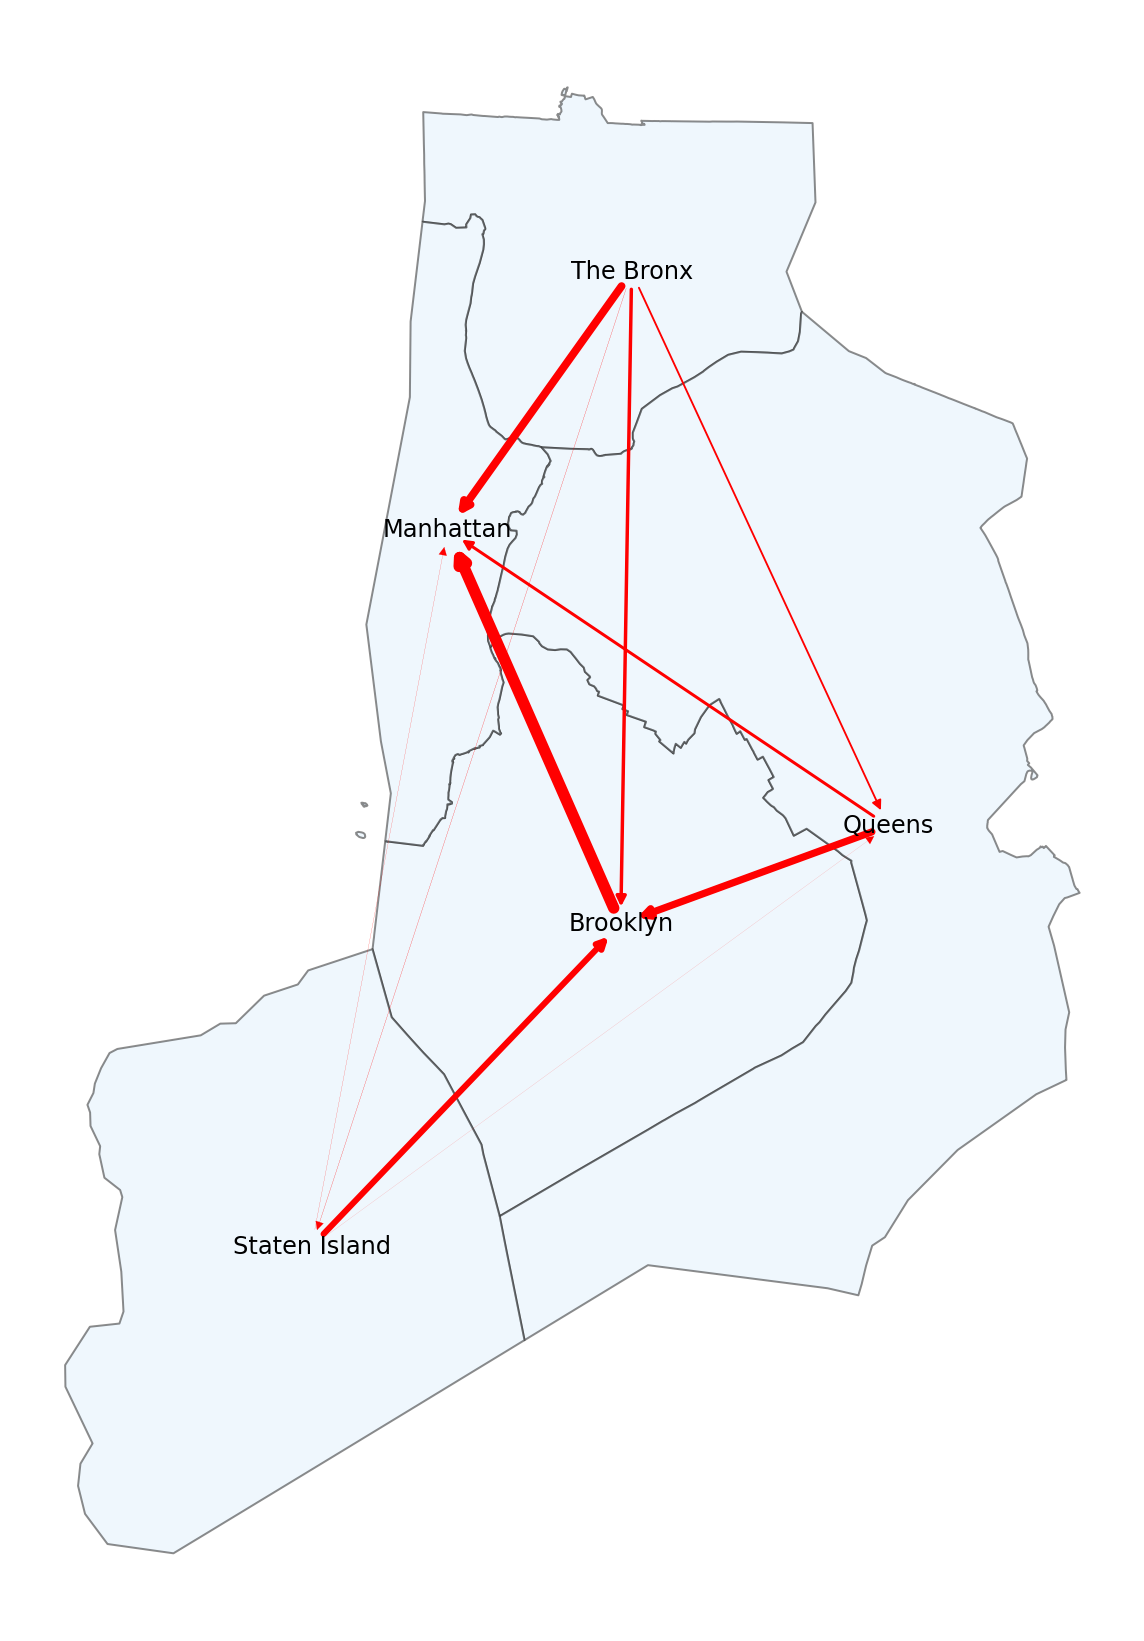

In [172]:
fig, ax = plt.subplots(figsize=(10, 20))
ax.axis("off")
nyc_county_gdf.plot(ax=ax, edgecolor="0.1", linewidth=1, color="#e1f1fd", alpha=0.5)

pos = {
    borough: cast_point(nyc_county_gdf.loc[county_fips].geometry.representative_point())
    for borough, county_fips in nyc_county_fips_codes.items()
}   
#nx.draw_networkx_nodes(net_migration_graph, pos, ax=ax)
nx.draw_networkx_labels(net_migration_graph, pos, ax=ax)

for edge in net_migration_graph.edges(data='weight'):
    nx.draw_networkx_edges(net_migration_graph, pos, edgelist=[edge], width=0.0006 * edge[2], ax=ax, edge_color="red")

### Migration and opportunity

In [ ]:
# Estimate!!Median age --!!Total:
median_age_column = "B01002_001E"

# Estimate!!Median income in the past 12 months --!!Total:
median_income_column = "B06011_001E"

In [ ]:
county_tract_acs_df = pd.DataFrame(
    census.acs5.get(
        (median_age_column, median_income_column),
        geo={
            "for": "county:*",
            "in": f"state:{state_fips}",
        },
        year=2020,
    )
)

(TODO...)